# Random vs stratified sampling

We compare the predictions of infected individuals for the following sampling strategies in EpiOS:
- Random
- Age stratification
- Region stratification

Imports

In [49]:
import epios

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [50]:
path = '.'
# This assumes the python venv is installed under EpiOS folder
demo_data = pd.read_csv(f'{path}/simulation_outputs/demographics.csv')
time_data = pd.read_csv(f'{path}/simulation_outputs/inf_status_history.csv')

In [51]:
def predict_base(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Base` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Base(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, base_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + base_prediction
    base_prediction_age_groups = post_process.predict.result_ages
    base_prediction_regions = post_process.predict.result_regions

    return times, true, base_prediction, base_prediction_age_groups, base_prediction_regions

In [52]:
def predict_age(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Age` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Age(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, age_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + age_prediction
    age_prediction_age_groups = post_process.predict.result_ages
    age_prediction_regions = post_process.predict.result_regions

    return times, true, age_prediction, age_prediction_age_groups, age_prediction_regions

In [53]:
def predict_region(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Region` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Region(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, region_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + region_prediction
    region_prediction_age_groups = post_process.predict.result_ages
    region_prediction_regions = post_process.predict.result_regions

    return times, true, region_prediction, region_prediction_age_groups, region_prediction_regions

### Finding samples using Random, Age, and Region methods

In [54]:
def rand(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the Random sampling strategies,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    random = predict_base(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, base_pred, base_pred_age_groups, base_pred_regions = random

    return times, true, base_pred, base_pred_age_groups, base_pred_regions

In [55]:
def age(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the age stratification, without plotting.
    These will be averaged over multiple runs

    Returns
    -------
    np.array
        Predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    age_strat = predict_age(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, age_pred, age_pred_age_groups, age_pred_regions = age_strat

    return times, true, age_pred, age_pred_age_groups, age_pred_regions

In [56]:
def region(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the region stratification,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    region = predict_region(post_process=post_process,
                            sample_size=sample_size,
                            time_sample=time_sample,
                            comparison=comparison,
                            sample_strategy='Random')
    times, true, region_pred, region_pred_age_groups, region_pred_regions = region

    return times, true, region_pred, region_pred_age_groups, region_pred_regions

### Calculating the true number of infections per age group

In [57]:
def count_people_by_age_group(demo_data, time_data, time_sample, num_age_group=17, age_group_width=5):
    """
    Count the true number of people within each age group that are infected.

    Parameters
    ----------
    demo_data: pandas.DataFrame
        Demographic data of the population
    time_data: pandas.DataFrame
        The infection data of the population at different time points
    time_sample: list
        A list of time points to sample the population
    num_age_group: int
        Number of age groups within the population
    age_group_width: int
        Number of ages within an age group

    Returns
    -------
    total_count_age_groups: list[list, ...]
        A list containing a list of infection totals for each time point. Here,
        each list represents an age group
    total_by_age: list
        A list containing the total number of individuals in each age group
    """
    df = demo_data
    inf_history = time_data
    total_count_age_groups = []
    total_by_age = []

    # Group data by age groups
    for i in range(num_age_group):
        min_age = i * age_group_width
        max_age = min_age + age_group_width
        if i == num_age_group - 1:
            max_age = float('inf')  # Last group includes age >= some threshold

        age_group_data = df[df['age'].between(min_age, max_age-0.01)]

        selected_columns = [col for col in inf_history.columns if str(col) in age_group_data['id'].astype(str).values]
        selected_data = inf_history[selected_columns]

        selected_data = selected_data.iloc[time_sample]

        people_by_age = len(selected_data.columns)
        count_by_age_group = selected_data.apply(lambda row: row.isin(range(3, 9)).sum(), axis=1).tolist()
        total_count_age_groups.append(count_by_age_group)
        total_by_age.append(people_by_age)

    return total_count_age_groups, total_by_age

### Calculating the true number of infections per region

In [58]:
def count_people_by_region(demo_data, time_data, time_sample):
    """
    Count the true number of people within each region that are infected.

    Parameters
    ----------
    demo_data: pandas.DataFrame
        Demographic data of the population
    time_data: pandas.DataFrame
        The infection data of the population at different time points
    time_sample: list
        A list of time points to sample the population

    Returns
    -------
    total_count_regions: list[list, ...]
        A list containing a list of infection totals for each time point. Here,
        each list represents a region
    total_by_region: list
        A list containing the total number of individuals in each region
    """
    inf_history = time_data
    last_row = demo_data.iloc[-1]
    region_id = int(last_row['id'].split('.')[0])
    total_by_region = []
    total_count_regions = []
    for region in range(region_id + 1):
        region_columns = [col for col in inf_history.columns if str(col).startswith(f'{region}.')]
        selected_data = inf_history[region_columns]
        selected_data = selected_data.iloc[time_sample]
        count_regions = selected_data.apply(lambda row: row.isin(range(3, 9)).sum(), axis=1).tolist()
        total_count_regions.append(count_regions)
        total_by_region.append(len(inf_history[region_columns].columns))

    return total_count_regions, total_by_region

In [59]:
time_sample = [num for num in range(300)]
true_age_grouped_infections, total_by_age_groups = count_people_by_age_group(demo_data, time_data, time_sample)
true_regional_infections, total_by_region = count_people_by_region(demo_data, time_data, time_sample)

### Initialising the post process

In [136]:
post_process = epios.PostProcess(demo_data=demo_data, time_data=time_data)

# Initialise the predictions
base_pred_iterations = []
age_pred_iterations = []
region_pred_iterations = []
age_grouped_results = []
regional_results = []


### Here will we find the total prediction and the stratified predictions

In [139]:
num_iters = 50
start_time = time.time()
for j in range(num_iters):
    predictions = rand(post_process=post_process,
                       sample_size=10,
                       time_sample=time_sample,
                       comparison=True)
    times, true, base_pred, base_pred_age_groups, base_pred_regions = predictions

    age_predictions = age(post_process=post_process,
                          sample_size=10,
                          time_sample=time_sample,
                          comparison=True)
    age_pred, age_pred_age_groups, age_pred_regions = age_predictions[2], age_predictions[3], age_predictions[4]

    region_predictions = region(post_process=post_process,
                                sample_size=10,
                                time_sample=time_sample,
                                comparison=True)
    region_pred, region_pred_age_groups, region_pred_regions = region_predictions[2], region_predictions[3], region_predictions[4]

    print(f"Iteration {j}")

    base_pred_iterations.append(np.array(base_pred))
    age_pred_iterations.append(np.array(age_pred))
    region_pred_iterations.append(np.array(region_pred))

    # Create a dictionary representing the iteration result
    iteration_age_result = {'Iteration': j,
                        'Base Prediction': np.array(base_pred_age_groups, dtype='float64'),
                        'Age Prediction': np.array(age_pred_age_groups, dtype='float64'),
                        'Region Prediction': np.array(region_pred_age_groups, dtype='float64')}

    # Append the iteration result to the list
    if j >= len(age_grouped_results):
        age_grouped_results.append(iteration_age_result)

    iteration_region_result = {'Iteration': j,
                        'Base Prediction': np.array(base_pred_regions, dtype='float64'),
                        'Age Prediction': np.array(age_pred_regions, dtype='float64'),
                        'Region Prediction': np.array(region_pred_regions, dtype='float64')}

    if j >= len(regional_results):
        regional_results.append(iteration_region_result)

age_results_df = pd.DataFrame(age_grouped_results)
regional_results_df = pd.DataFrame(regional_results)

Iteration 0
[{'Iteration': 0, 'Base Prediction': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 1. ],
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]]), 'Age Prediction': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'Region Prediction': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.5],
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ]])}]
Iteration 1
[{'Iteration': 0, 'Base Prediction': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.

### Averaging the predictions across the 50 iterations

Base predictions

In [ ]:
base_pred_array = np.zeros_like(base_pred_iterations[0])

for arr in base_pred_iterations:
    base_pred_array += arr
base_pred_array = base_pred_array / num_iters
base_pred_avg = base_pred_array.tolist()


Age stratified predictions

In [ ]:
age_pred_array = np.zeros_like(age_pred_iterations[0])

for arr in age_pred_iterations:
    age_pred_array += arr
age_pred_array = age_pred_array / num_iters
age_pred_avg = age_pred_array.tolist()

Region stratified predictions

In [ ]:
region_pred_array = np.zeros_like(region_pred_iterations[0])

for arr in region_pred_iterations:
    region_pred_array += arr
region_pred_array = region_pred_array / num_iters
region_pred_avg = region_pred_array.tolist()

### Saving to .csv files

In [174]:
true_total = pd.DataFrame(true)
true_age_grouped_infections = pd.DataFrame(true_age_grouped_infections)
true_regional_infections = pd.DataFrame(true_regional_infections)
total_by_age_groups = pd.DataFrame(total_by_age_groups)
total_by_region = pd.DataFrame(total_by_region)
base_pred_iterations = pd.DataFrame(base_pred_iterations)
age_pred_iterations = pd.DataFrame(age_pred_iterations)
region_pred_iterations = pd.DataFrame(region_pred_iterations)

true_total.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/true_total_infections_10.csv')
true_age_grouped_infections.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/true_infections_age_group_10.csv')
true_regional_infections.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/true_infections_regions_10.csv')
total_by_age_groups.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/total_by_age_group_10.csv')
total_by_region.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/total_by_regions_10.csv')
base_pred_iterations.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/predictions_10.csv')
age_pred_iterations.to_csv('C:/Users/evana/EpiOS/stratified_random/age_strategy/predictions_10.csv')
region_pred_iterations.to_csv('C:/Users/evana/EpiOS/stratified_random/region_strategy/predictions_10.csv')
age_results_df.to_csv('C:/Users/evana/EpiOS/stratified_random/age_strategy/predictions_by_age_10.csv')
regional_results_df.to_csv('C:/Users/evana/EpiOS/stratified_random/region_strategy/predictions_by_region_10.csv')

### Reading from .csv files

In [253]:
import pandas as pd
from itertools import chain

true_age_grouped_infections = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/true_infections_age_group_10.csv')
true_age_grouped_lists = true_age_grouped_infections.iloc[:, 2:].values.tolist()

true_region_infections = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/true_infections_regions_10.csv')
true_region_lists = true_region_infections.iloc[:, 1:].values.tolist()

total_by_age_groups = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/total_by_age_group_10.csv')
total_by_age_groups_lists = list(chain.from_iterable(total_by_age_groups.iloc[:, 2:].values.tolist()))

total_by_region = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/total_by_regions_10.csv')
total_by_region_lists = list(chain.from_iterable(total_by_region.iloc[:, 2:].values.tolist()))

base_pred_infections = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/predictions_10.csv')
base_pred_lists = base_pred_infections.iloc[:, 1:].values.tolist()

age_pred_infections = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/age_strategy/predictions_10.csv')
age_pred_lists = age_pred_infections.iloc[:, 1:].values.tolist()

region_pred_infections = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/region_strategy/predictions_10.csv')
region_pred_lists = region_pred_infections.iloc[:, 1:].values.tolist()

# age_results_df_try = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/age_strategy/predictions_by_age_10.csv', index_col=False)
# regional_results_df_try = pd.read_csv('C:/Users/evana/EpiOS/stratified_random/region_strategy/predictions_by_region_10.csv', index_col=False, escapechar='\\')


### Calculating RMSE

Age predictions

In [251]:
base_rmse_list = []
age_rmse_list = []
region_rmse_list = []
base_avg_rmse_age = []
age_avg_rmse_age = []
region_avg_rmse_age = []

print(total_by_age_groups_lists)

for row in age_results_df['Base Prediction']:
    aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(row)]
    sublist_diff = [np.sqrt((np.array(total)-np.array(sublist))**2).mean() for sublist, total in zip(aged, true_age_grouped_lists)]
    base_rmse_list.append(sublist_diff)

base_rmse_df = pd.DataFrame(base_rmse_list)
for column in range(len(age_results_df['Base Prediction'][0])):
    base_avg_rmse_age.append(np.mean(base_rmse_df.iloc[:, column]))


for row in age_results_df['Age Prediction']:
    aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(row)]
    sublist_diff = [np.sqrt((np.array(total)-np.array(sublist))**2).mean() for sublist, total in zip(aged, true_age_grouped_lists)]
    age_rmse_list.append(sublist_diff)

age_rmse_df = pd.DataFrame(age_rmse_list)
for column in range(len(age_results_df['Age Prediction'][0])):
    age_avg_rmse_age.append(np.mean(age_rmse_df.iloc[:, column]))

for row in age_results_df['Region Prediction']:
    aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(row)]
    sublist_diff = [np.sqrt((np.array(total)-np.array(sublist))**2).mean() for sublist, total in zip(aged, true_age_grouped_lists)]
    region_rmse_list.append(sublist_diff)

region_rmse_df = pd.DataFrame(region_rmse_list)
for column in range(len(age_results_df['Region Prediction'][0])):
    region_avg_rmse_age.append(np.mean(region_rmse_df.iloc[:, column]))

[2009, 2211, 2282, 2165, 1669, 1722, 2037, 2496, 3013, 2653, 2216, 1984, 1544, 1240, 1144, 1070, 1623]


Regional predictions

In [254]:
base_rmse_list = []
age_rmse_list = []
region_rmse_list = []
base_avg_rmse_region = []
age_avg_rmse_region = []
region_avg_rmse_region = []

print(total_by_region_lists)

for row in regional_results_df['Base Prediction']:
    aged = [sublist * total_by_region_lists[i] for i, sublist in enumerate(row)]
    sublist_diff = [np.sqrt((np.array(total)-np.array(sublist))**2).mean() for sublist, total in zip(aged, true_region_lists)]
    base_rmse_list.append(sublist_diff)

base_rmse_df = pd.DataFrame(base_rmse_list)
for column in range(len(regional_results_df['Base Prediction'][0])):
    base_avg_rmse_region.append(np.mean(base_rmse_df.iloc[:, column]))


for row in regional_results_df['Age Prediction']:
    aged = [sublist * total_by_region_lists[i] for i, sublist in enumerate(row)]
    sublist_diff = [np.sqrt((np.array(total)-np.array(sublist))**2).mean() for sublist, total in zip(aged, true_region_lists)]
    age_rmse_list.append(sublist_diff)

age_rmse_df = pd.DataFrame(age_rmse_list)
for column in range(len(regional_results_df['Age Prediction'][0])):
    age_avg_rmse_region.append(np.mean(age_rmse_df.iloc[:, column]))

for row in regional_results_df['Region Prediction']:
    aged = [sublist * total_by_region_lists[i] for i, sublist in enumerate(row)]
    sublist_diff = [np.sqrt((np.array(total)-np.array(sublist))**2).mean() for sublist, total in zip(aged, true_region_lists)]
    region_rmse_list.append(sublist_diff)

region_rmse_df = pd.DataFrame(region_rmse_list)
for column in range(len(regional_results_df['Region Prediction'][0])):
    region_avg_rmse_region.append(np.mean(region_rmse_df.iloc[:, column]))

[81, 1494, 7190, 1726, 6777, 3569, 4909, 938, 2816, 1032, 761, 1785]


Total infection predictions

In [228]:
base_pred_array = np.zeros_like(base_pred_lists[0])
age_pred_array = np.zeros_like(age_pred_lists[0])
region_pred_array = np.zeros_like(region_pred_lists[0])
base_pred_rmse = []
age_pred_rmse = []
region_pred_rmse = []

for arr in base_pred_lists:
    base_pred_array += arr
    base_pred_rmse.append(np.sqrt((true-arr)**2).mean())
base_pred_array = base_pred_array / num_iters
base_pred_avg = base_pred_array.tolist()
print(base_pred_rmse)

for arr in age_pred_lists:
    age_pred_array += arr
    age_pred_rmse.append(np.sqrt((true-arr)**2).mean())
age_pred_array = age_pred_array / num_iters
age_pred_avg = age_pred_array.tolist()
print(age_pred_rmse)

for arr in region_pred_lists:
    region_pred_array += arr
    region_pred_rmse.append(np.sqrt((true-arr)**2).mean())
region_pred_array = region_pred_array / num_iters
region_pred_avg = region_pred_array.tolist()
print(region_pred_rmse)



[3415.216, 3297.987333333333, 3284.3153333333335]
[3573.2153333333335, 3305.868666666667, 3340.658]
[3494.288, 3352.9106666666667, 3207.800666666667]


### Calculating the confidence interval of the predictions

In [233]:
print(len(base_pred_lists)) # Number of iterations

base_std_deviation = (np.std(np.array(base_pred_lists), axis=0))
age_std_deviation = (np.std(np.array(age_pred_lists), axis=0))
region_std_deviation = (np.std(np.array(region_pred_lists), axis=0))

base_confidence_interval_upper = (np.array(base_pred_avg) + (1.96 * base_std_deviation / np.sqrt(50))).tolist()
base_confidence_interval_lower = (np.array(base_pred_avg) - (1.96 * base_std_deviation / np.sqrt(50))).tolist()
age_confidence_interval_upper = (np.array(age_pred_avg) + (1.96 * age_std_deviation / np.sqrt(50))).tolist()
age_confidence_interval_lower = (np.array(age_pred_avg) - (1.96 * age_std_deviation / np.sqrt(50))).tolist()
region_confidence_interval_upper = (np.array(region_pred_avg) + (1.96 * region_std_deviation / np.sqrt(50))).tolist()
region_confidence_interval_lower = (np.array(region_pred_avg) - (1.96 * region_std_deviation / np.sqrt(50))).tolist()
print(base_confidence_interval_upper)


3
[0.0, 0.0, 0.0, 2086.1192, 0.0, 0.0, 0.0, 4172.2384, 0.0, 2086.1192, 0.0, 3740.0192, 0.0, 5710.325614406775, 6258.357599999999, 13663.4192, 4961.700000000001, 6258.357599999999, 9923.400000000001, 26105.1576, 13663.4192, 19057.3384, 17682.54451506729, 22644.244515067287, 19336.44451506729, 21344.05122881355, 23059.088487840025, 26105.1576, 21143.457599999998, 21143.457599999998, 24712.988487840026, 19057.3384, 19057.3384, 13663.4192, 9827.888487840026, 16971.2192, 5710.325614406775, 8701.7192, 11220.0576, 13461.299814257995, 14885.099999999999, 10672.025614406775, 10672.025614406775, 13663.4192, 7047.8192, 7047.8192, 12009.519199999999, 4961.700000000001, 8344.4768, 9923.400000000001, 4961.700000000001, 5710.325614406775, 9133.9384, 9133.9384, 2086.1192, 5710.325614406775, 5710.325614406775, 10672.025614406775, 5710.325614406775, 4172.2384, 8701.7192, 12009.519199999999, 3740.0192, 7480.0384, 10672.025614406775, 10672.025614406773, 13663.4192, 7480.0384, 9827.888487840026, 13663.4192

## Plots

Here we are plotting the true infection total against the prediction

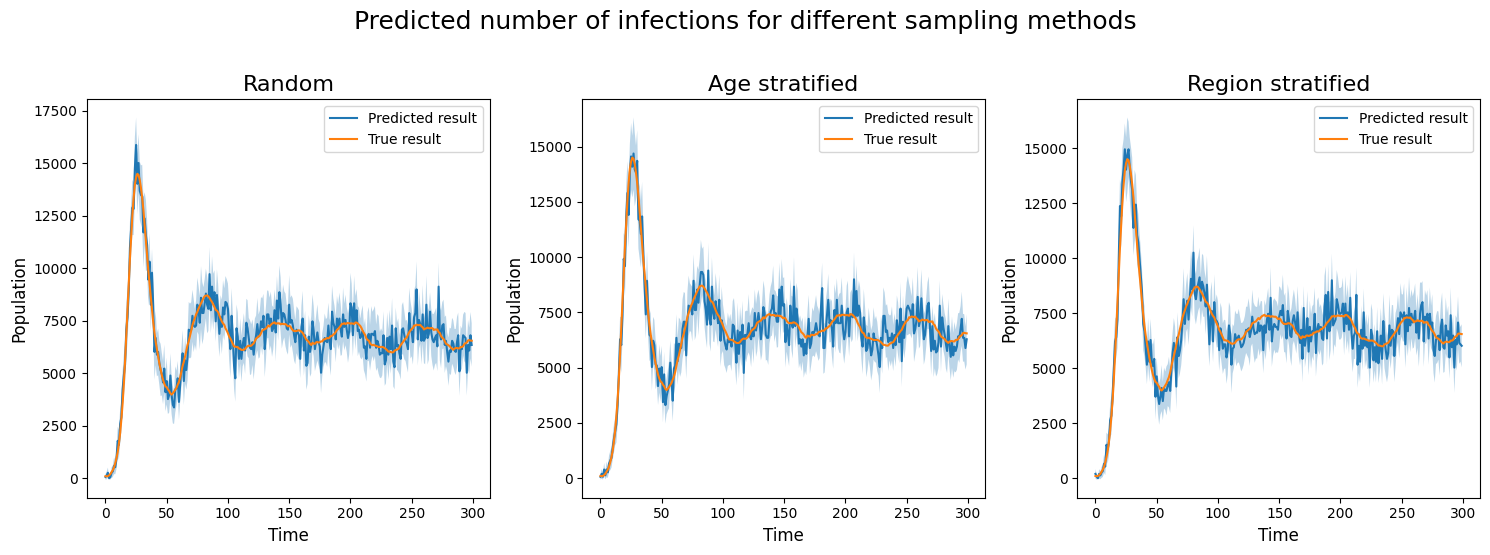

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axs[0].plot(time_sample, base_pred_avg, label='Predicted result')
axs[0].plot(time_sample, true, label='True result')
axs[0].fill_between(time_sample, base_confidence_interval_lower, base_confidence_interval_upper, alpha=0.3)
axs[0].legend()
axs[0].set_xlabel('Time', fontsize='12')
axs[0].set_ylabel('Population', fontsize='12')
axs[0].set_title('Random', fontsize='16')

# Plot 2
axs[1].plot(time_sample, age_pred_avg, label='Predicted result')
axs[1].plot(time_sample, true, label='True result')
axs[1].fill_between(time_sample, age_confidence_interval_lower, age_confidence_interval_upper, alpha=0.3)
axs[1].legend()
axs[1].set_xlabel('Time', fontsize='12')
axs[1].set_ylabel('Population', fontsize='12')
axs[1].set_title('Age stratified', fontsize='16')

# Plot 3
axs[2].plot(time_sample, region_pred_avg, label='Predicted result')
axs[2].plot(time_sample, true, label='True result')
axs[2].fill_between(time_sample, region_confidence_interval_lower, region_confidence_interval_upper, alpha=0.3)
axs[2].legend()
axs[2].set_xlabel('Time', fontsize='12')
axs[2].set_ylabel('Population', fontsize='12')
axs[2].set_title('Region stratified', fontsize='16')

plt.tight_layout()
plt.suptitle('Predicted number of infections for different sampling methods', y=1.1, fontsize='18')
plt.show()
plt.clf()


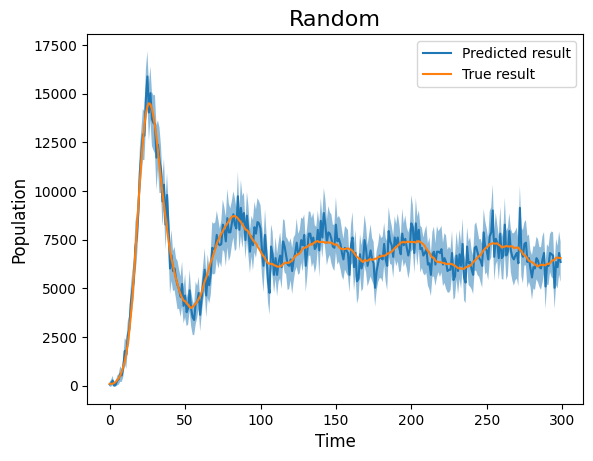

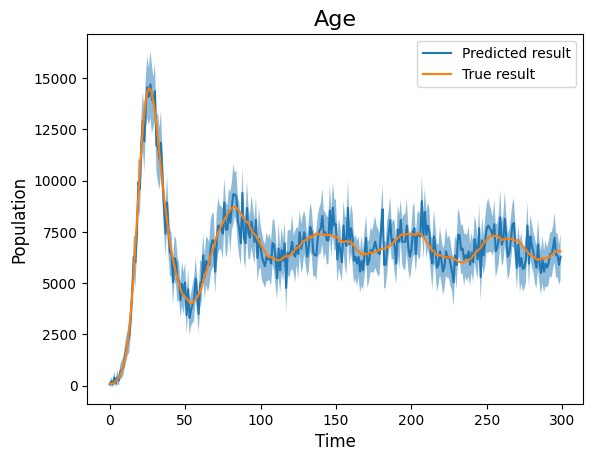

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(time_sample, base_pred_avg, label='Predicted result')
plt.plot(time_sample, true, label='True result')
plt.fill_between(time_sample, base_confidence_interval_lower, base_confidence_interval_upper, alpha=0.5)
plt.legend()
plt.xlabel('Time', fontsize='12')
plt.ylabel('Population', fontsize='12')
plt.title('Random', fontsize='16')
plt.show()
plt.clf()

plt.plot(time_sample, age_pred_avg, label='Predicted result')
plt.plot(time_sample, true, label='True result')
plt.fill_between(time_sample, age_confidence_interval_lower, age_confidence_interval_upper, alpha=0.5)
plt.legend()
plt.xlabel('Time', fontsize='12')
plt.ylabel('Population', fontsize='12')
plt.title('Age', fontsize='16')
plt.show()
plt.clf()

Here we are plotting the RMSE for each sampling method for the total, age, and region predictions

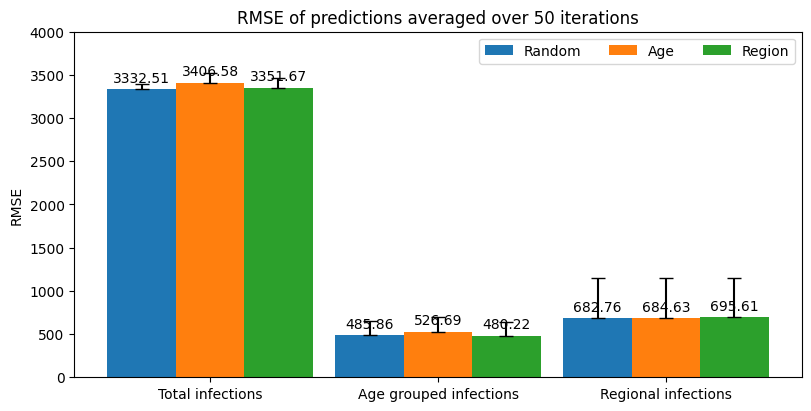

In [257]:
# Make bar chart of average RMSE for base, age, and region predictions
sampling = ("Total infections", "Age grouped infections", "Regional infections")
rmse_values = {
    'Random': (round(np.mean(base_pred_rmse), 2), round(np.mean(base_avg_rmse_age), 2), round(np.mean(base_avg_rmse_region), 2)),
    'Age': (round(np.mean(age_pred_rmse), 2), round(np.mean(age_avg_rmse_age), 2), round(np.mean(age_avg_rmse_region), 2)),
    'Region': (round(np.mean(region_pred_rmse), 2), round(np.mean(region_avg_rmse_age), 2), round(np.mean(region_avg_rmse_region), 2)),
}
error_values = {
    'Random': [np.std(base_pred_rmse), np.std(base_avg_rmse_age), np.std(base_avg_rmse_region)],
    'Age': [np.std(age_pred_rmse), np.std(age_avg_rmse_age), np.std(age_avg_rmse_region)],
    'Region': [np.std(region_pred_rmse), np.std(region_avg_rmse_age), np.std(region_avg_rmse_region)],
}
x = np.arange(len(sampling))  # Label locations
width = 0.3  # Width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

for attribute, measurement in rmse_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    for i, rect in enumerate(rects):
        ax.errorbar(rect.get_x() + rect.get_width() / 2, measurement[i], yerr=[[0], [error_values[attribute][i]]],
                    capsize=5, color='black')
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('RMSE')
ax.set_title('RMSE of predictions averaged over 50 iterations')
ax.set_xticks(x + width, sampling)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 4000)

plt.show()

We can see the distribution of individuals by age and region

[2009, 2211, 2282, 2165, 1669, 1722, 2037, 2496, 3013, 2653, 2216, 1984, 1544, 1240, 1144, 1070, 1623]
[81, 1494, 7190, 1726, 6777, 3569, 4909, 938, 2816, 1032, 761, 1785]


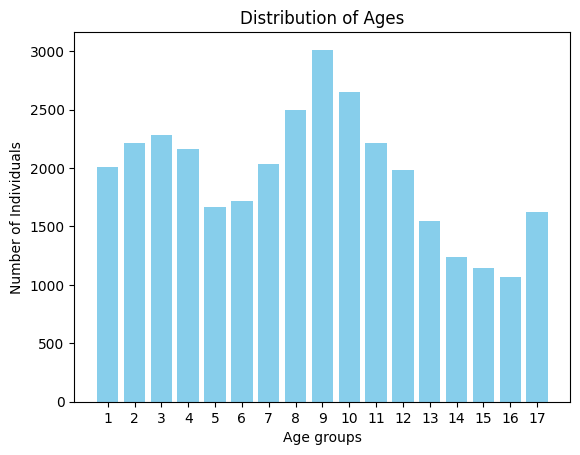

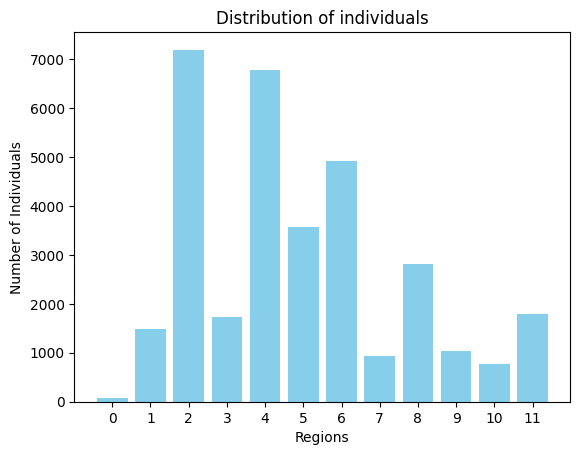

<Figure size 640x480 with 0 Axes>

In [ ]:
age_groups = [_+1 for _ in range(len(total_by_age_groups_lists))]
regions = [_ for _ in range(len(total_by_region_lists))]
num_people = total_by_age_groups_lists
num_people_regions = total_by_region_lists

plt.bar(age_groups, num_people, color='skyblue')
plt.xlabel('Age groups')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Ages')
plt.xticks(age_groups)
plt.show()
plt.clf()

plt.bar(regions, num_people_regions, color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Number of Individuals')
plt.title('Distribution of individuals')
plt.xticks(regions)
plt.show()
plt.clf()